<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-07/W-GAN-GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


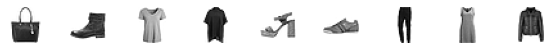

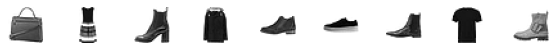

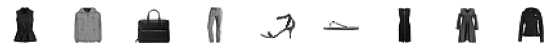

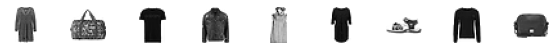

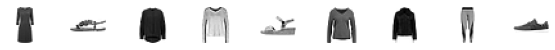

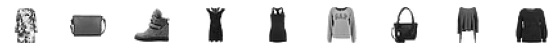

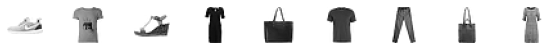

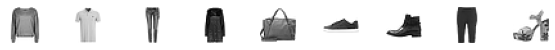

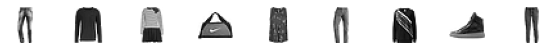

In [4]:
from tensorflow.keras.datasets import fashion_mnist, mnist

(trainX, trainY), (testX, testY) = fashion_mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))


for k in range(9):
    plt.figure(figsize=(10, 7))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

In [5]:
#Ten classes
set(trainY)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [6]:
trainX = [(image-127.5)/127.5 for image in trainX]
testX = [(image-127.5)/127.5 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Generator Model

In [7]:
random_input = tensorflow.keras.layers.Input(shape = 100)

x = tensorflow.keras.layers.Dense(7*7*128)(random_input)
x = tensorflow.keras.layers.Reshape((7, 7, 128))(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.Activation('relu')(x)

x = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(4,4), padding='same')(x)
generated_image = tensorflow.keras.layers.Activation('tanh')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       147584

# Critic

In [8]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same')(image_input)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same')(x)
x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)

x = tensorflow.keras.layers.Flatten()(x)

c_out = tensorflow.keras.layers.Dense(1)(x)

critic_network = tensorflow.keras.models.Model(inputs=image_input, outputs=c_out)

print (critic_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0   

# Compiling Classisfiers

In [9]:
# custom loss function
def wasserstein_loss(y_true, y_pred):
    return tensorflow.keras.backend.mean(y_true * y_pred)

In [10]:
# This cell code is taken from: https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py
import keras
from functools import partial
import keras.backend as K
from keras.layers import Layer

# class RandomWeightedAverage(Layer):
#     """Provides a (random) weighted average between real and generated image samples"""
#     def _merge_function(self, inputs):
#         alpha = K.random_uniform((32, 1, 1, 1))
#         return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class RandomWeightedAverage(Layer):
    def call(self, inputs, **kwargs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

def gradient_penalty_loss(y_true, y_pred, averaged_samples):
    """
    Computes gradient penalty based on prediction and weighted real / fake samples
    """
    gradients = K.gradients(y_pred, averaged_samples)[0]
    # compute the euclidean norm by squaring ...
    gradients_sqr = K.square(gradients)
    #   ... summing over the rows ...
    gradients_sqr_sum = K.sum(gradients_sqr,
                              axis=np.arange(1, len(gradients_sqr.shape)))
    #   ... and sqrt
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    # compute lambda * (1 - ||grad||)^2 still for each single sample
    gradient_penalty = K.square(1 - gradient_l2_norm)
    # return the mean as loss over all the batch samples
    return K.mean(gradient_penalty)

In [11]:
RMSprop_optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.00005)

real_img = tensorflow.keras.Input(shape=(28, 28, 1))
fake_img = tensorflow.keras.Input(shape=(28, 28, 1))

interpolated_img = RandomWeightedAverage()([real_img, fake_img])
c_out_interpolated = critic_network(interpolated_img)

partial_gp_loss = partial(gradient_penalty_loss,
                          averaged_samples=interpolated_img)
partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

fake = critic_network(fake_img)
real = critic_network(real_img)

critic_model = tensorflow.keras.models.Model(inputs=[real_img, random_input], outputs=[real, fake, c_out_interpolated])

critic_model.compile(loss=[wasserstein_loss, wasserstein_loss, partial_gp_loss], optimizer=RMSprop_optimizer, metrics=['accuracy'], loss_weights=[1,1,10])

ValueError: ignored

# GAN

In [ ]:
critic_network.trainable=False

g_output = generator_network(random_input)
c_output = critic_network(g_output)

wgan_model = tensorflow.keras.models.Model(inputs = random_input, outputs = c_output)
wgan_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
functional_1 (Functional)    (None, 28, 28, 1)         1982145   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 1224065   
Total params: 3,206,210
Trainable params: 1,981,377
Non-trainable params: 1,224,833
_________________________________________________________________


# Compiling InfoGAN

In [ ]:
wgan_model.compile(loss='binary_crossentropy', optimizer=RMSprop_optimizer)

# Define Data Generators

In [ ]:
indices = [i for i in range(0, len(trainX))]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batches = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batches

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batches = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batches)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    for k in range(5):
        plt.figure(figsize=(10, 7))
        random_noise_batches = get_random_noise(5, noise_size) 
        fake_samples = generator_network.predict_on_batch(random_noise_batches)
        for j in range(5):
            i = j
            plt.subplot(550 + 1 + j)
            plt.imshow(fake_samples[i,:,:,-1], cmap='gray_r')
            plt.axis('off')
        plt.show()
    return

# Training GAN

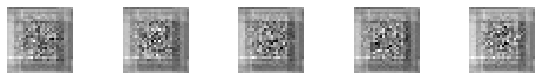

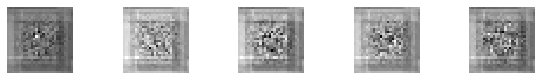

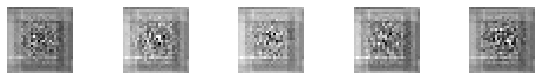

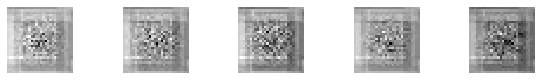

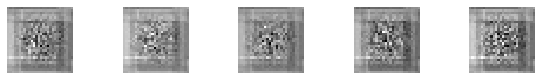

C_real_loss: -0.008, C_fake_loss: 0.000, C_loss: -0.004
C_real_loss: -0.008, C_fake_loss: 0.000, C_loss: -0.004
C_real_loss: -0.008, C_fake_loss: 0.000, C_loss: -0.004
C_real_loss: -0.008, C_fake_loss: 0.000, C_loss: -0.004
C_real_loss: -0.008, C_fake_loss: 0.000, C_loss: -0.004
Epoch:0, Step:0, C-Loss:-0.004, C-Acc:50.000, G-Loss:15.425


KeyboardInterrupt: 

In [ ]:
epochs = 500
batch_size = 100
steps = 500
noise_size = 100

for i in range(0, epochs):
    if (i%10 == 0):
        op = show_generator_results(generator_network)
        #print (op)
    for j in range(steps):
        # With Number of Critics=5
        for _ in range(5):
            fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
            real_samples = get_real_samples(batch_size=batch_size//2)

            fake_y = np.zeros((batch_size//2, 1))
            real_y = np.ones((batch_size//2, 1))

            # Updating Critic weights

            critic_network.trainable=True
            loss_c_real = critic_network.train_on_batch(real_samples, real_y)
            loss_c_fake = critic_network.train_on_batch(fake_samples, fake_y)
            
            loss_c = np.add(loss_c_real, loss_c_fake)/2.0

            # Clip critic weights
            for l in critic_network.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -0.01, 0.01) for w in weights]
                l.set_weights(weights)
            
            if j%50==0:
                print ("C_real_loss: %.3f, C_fake_loss: %.3f, C_loss: %.3f"%(loss_c_real[0], loss_c_fake[0], loss_c[0]))
        
        noise_batches = get_random_noise(batch_size, noise_size)
        
        wgan_input = noise_batches
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        wgan_output = np.ones((batch_size))
        
        # Updating Generator weights
        critic_network.trainable=False
        loss_g = wgan_model.train_on_batch(wgan_input, wgan_output)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, C-Loss:%.3f, C-Acc:%.3f, G-Loss:%.3f"%\
                   (i,j,loss_c[0],loss_c[1]*100,loss_g))